### Test

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

Epoch 1/50


C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


164/164 [==============================] - 1s 2ms/step - loss: -261.3990 - val_loss: -695.7401
Epoch 2/50
164/164 [==============================] - 0s 2ms/step - loss: -1309.8800 - val_loss: -2525.9048
Epoch 3/50
164/164 [==============================] - 0s 2ms/step - loss: -3658.9287 - val_loss: -6002.5498
Epoch 4/50
164/164 [==============================] - 0s 1ms/step - loss: -7468.2905 - val_loss: -11101.1641
Epoch 5/50
164/164 [==============================] - 0s 1ms/step - loss: -12711.1719 - val_loss: -17751.8418
Epoch 6/50
164/164 [==============================] - 0s 1ms/step - loss: -19227.4922 - val_loss: -25726.4883
Epoch 7/50
164/164 [==============================] - 0s 1ms/step - loss: -26881.6250 - val_loss: -34927.9883
Epoch 8/50
164/164 [==============================] - 0s 1ms/step - loss: -35581.3242 - val_loss: -45271.7422
Epoch 9/50
164/164 [==============================] - 0s 1ms/step - loss: -45278.9180 - val_loss: -56718.0938
Epoch 10/50
164/164 [=========

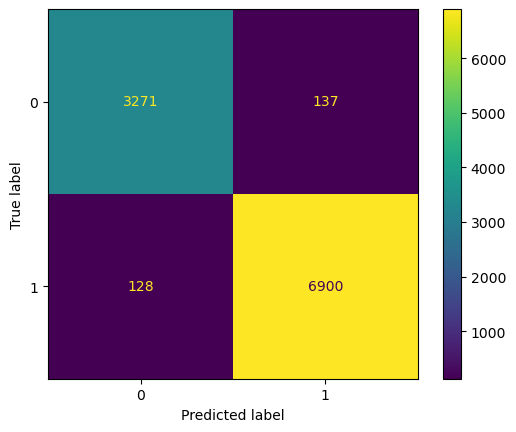

In [20]:

class AnomalyDetection:
    def __init__(self):
        self.data = pd.read_csv('US_Util_2020.csv')
        self.X_train_scaled = None
        self.X_test_scaled = None
        self.y_train = None
        self.y_test = None
    
    def preprocess(self):
        # Drop rows with any null values
        self.data.dropna(inplace=True)
        self.data.drop(['zip'], axis=1)
        
        # Convert all variables to numerical values if necessary
        for column in self.data.select_dtypes(include=['object']).columns:
            self.data[column] = self.data[column].astype('category').cat.codes

        # Select features and target
        X = self.data.drop('res_rate', axis=1)  # Update 'target' to your target column name
        y_cont = self.data['res_rate']
        y = np.where(y_cont > 0.1, 1, 0)  # Binarize based on the threshold
        
#         X = data.drop('res_rate', axis=1)  # Assuming 'target' is the column name of the continuous target variable
#         y_cont = data['res_rate']
    
#         y = np.where(y_cont > 0.1, 1, 0)  # Define `threshold` based on your domain knowledge
        
        
        # Feature selection using SelectKBest
        selector = SelectKBest(f_classif, k=4)  # Adjust k as needed
        X_selected = selector.fit_transform(X, y)
        
        # Dimensionality reduction with Sparse Autoencoder
        input_dim = X_selected.shape[1]
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(100, activation='relu', activity_regularizer=l1(10e-5))(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)
        
        encoder = Model(input_layer, encoded)
        X_reduced = encoder.predict(X_selected)
        
        # Split the data into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
        
        # Scale the features
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(self.X_train)
        self.X_test_scaled = scaler.transform(self.X_test)

    def run_model(self):
        # Initialize Isolation Forest
        iso_forest = IsolationForest(contamination=0.1, n_estimators=200, random_state=42)
        iso_forest.fit(self.X_train_scaled)

        # Filter normal data as per isolation forest
        isof_outcome = iso_forest.predict(self.X_train_scaled) == 1
        X_train_filtered = self.X_train_scaled[isof_outcome]
        y_train_filtered = self.y_train[isof_outcome]
        
        # Initialize and fit XGBoost
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        xgb.fit(X_train_filtered, y_train_filtered)
        
        # Predict on test data
        y_pred = xgb.predict(self.X_test_scaled)
        
        # Evaluation
        precision = precision_score(self.y_test, y_pred, average='weighted')
        recall = recall_score(self.y_test, y_pred, average='weighted')
        f1 = f1_score(self.y_test, y_pred, average='weighted')
        print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}')
        
        print(classification_report(self.y_test, y_pred))
        
        # Confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

# Usage
ad = AnomalyDetection()
ad.preprocess()
ad.run_model()


Epoch 1/50


C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


164/164 [==============================] - 1s 2ms/step - loss: -245.8145 - val_loss: -655.4326
Epoch 2/50
164/164 [==============================] - 0s 1ms/step - loss: -1181.5690 - val_loss: -2259.9087
Epoch 3/50
164/164 [==============================] - 0s 1ms/step - loss: -3284.8589 - val_loss: -5445.5112
Epoch 4/50
164/164 [==============================] - 0s 2ms/step - loss: -6882.8887 - val_loss: -10385.1328
Epoch 5/50
164/164 [==============================] - 0s 2ms/step - loss: -12030.4922 - val_loss: -16951.1543
Epoch 6/50
164/164 [==============================] - 0s 2ms/step - loss: -18487.9805 - val_loss: -24874.4062
Epoch 7/50
164/164 [==============================] - 0s 2ms/step - loss: -26114.3066 - val_loss: -34051.2539
Epoch 8/50
164/164 [==============================] - 0s 2ms/step - loss: -34782.7109 - val_loss: -44366.3242
Epoch 9/50
164/164 [==============================] - 0s 2ms/step - loss: -44457.5625 - val_loss: -55772.0586
Epoch 10/50
164/164 [=========

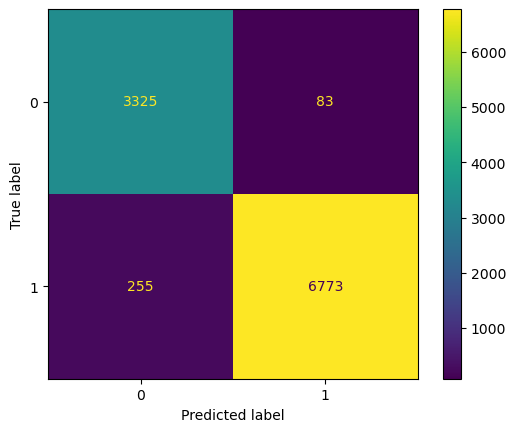

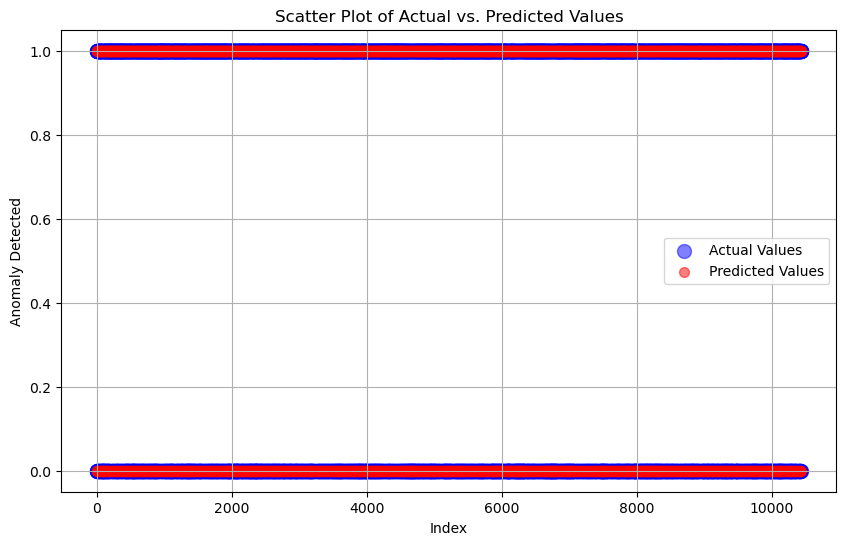

In [24]:

class AnomalyDetection:
        
    def __init__(self):
        self.data = pd.read_csv('US_Util_2020.csv')
        self.X_train_scaled = None
        self.X_test_scaled = None
        self.y_train = None
        self.y_test = None
        self.iso_forest = IsolationForest(contamination=0.1, n_estimators=200, random_state=42)

    def preprocess(self):
        self.data.dropna(inplace=True)
        self.data.drop(['zip'], axis=1)
        for column in self.data.select_dtypes(include=['object']).columns:
            self.data[column] = self.data[column].astype('category').cat.codes

        
        # Select features and target
        X = self.data.drop('res_rate', axis=1) 
        y_cont = self.data['res_rate']
        y = np.where(y_cont > 0.1, 1, 0)  # Binarize based on the threshold
        
        selector = SelectKBest(f_classif, k=4) # this one makes a difference on the model's performance when it is changed
        X_selected = selector.fit_transform(X, y)
        
        
        input_dim = X_selected.shape[1]
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(100, activation='relu', activity_regularizer=l1(10e-5))(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)
        
        encoder = Model(input_layer, encoded)
        X_reduced = encoder.predict(X_selected)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
        
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(self.X_train)
        self.X_test_scaled = scaler.transform(self.X_test)

    def fit_isolation_forest(self):
        self.iso_forest.fit(self.X_train_scaled)

    def filter_normal_data(self):
        isof_outcome = self.iso_forest.predict(self.X_train_scaled)
        normal_indices = np.where(isof_outcome == 1)[0]
        return self.X_train_scaled[normal_indices], self.y_train[normal_indices]

    def run_model(self):
        X_train_normal, y_train_normal = self.filter_normal_data()
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        xgb.fit(X_train_normal, y_train_normal)
        
        y_pred = xgb.predict(self.X_test_scaled)
        
        precision = precision_score(self.y_test, y_pred, average='binary')
        recall = recall_score(self.y_test, y_pred, average='binary')
        f1 = f1_score(self.y_test, y_pred, average='binary')
        
        print(classification_report(self.y_test, y_pred))
        
        print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}')
        
        cm = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        
        
        
        # Indices where the actual anomalies are present
        actual_anomalies = np.where(self.y_test == 1)[0]

        # Indices where anomalies are predicted
        predicted_anomalies = np.where(y_pred == 1)[0]

        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(self.y_test)), self.y_test, color='blue', label='Actual Values', alpha=0.5, s=100)
        plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', marke alpha=0.5, s=50)
        plt.title('Scatter Plot of Actual vs. Predicted Values')
        plt.xlabel('Index')
        plt.ylabel('Anomaly Detected')
        plt.legend()
        plt.grid(True)
        plt.show()
        

# Usage
ad = AnomalyDetection()
ad.preprocess()
ad.fit_isolation_forest()
ad.run_model()
